In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)
classpath = 'd:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar'

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;

In [3]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred, labels=[1, -1]):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        columns=['a(x) = '+str(labels[0]), 'a(x) = '+str(labels[1])],
        index=['y = '+str(labels[0]), 'y = '+str(labels[1])],
    ).T

In [4]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [5]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf
    
#Ada-boost sklearn
def get_predict_sklearn(X_train, X_test, y_train, y_test):
    clf = AdaBoostClassifier(n_estimators=150, random_state=0)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    return y_pred, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

#Java
def get_predicts_java_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostJavaClassifier_v1(path=classpath)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

In [6]:
REPEAT_COUNT = 3
TEST_SIZE = 0.33

### Simple separable dataset, 6 rows 4 features

In [7]:
X_train = np.array([[0.6476239, -0.81753611, -1.61389785, -0.21274028],
       [-2.3748206 ,  0.82768797, -0.38732682, -0.30230275],
       [ 1.51783379,  1.22140561, -0.51080514, -1.18063218],
       [-0.98740462,  0.99958558, -1.70627019,  1.9507754],
       [-1.43411205,  1.50037656, -1.04855297, -1.42001794],
       [ 0.29484027, -0.79249401, -1.25279536,  0.77749036]])

y_train = np.array([1, -1, -1, 1, 1, -1])

clf = AdaBoostStandardClassifier_v1(n_estimators=100)
result, history = clf.fit(X_train, y_train, trace=True)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Ada boost margin:", clf.get_margin_l1(X_train))
clf = AdaBoostLinear_v1()
result, message, log = clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Linear classifier margin: ", clf.get_margin())
clf = AdaBoostJavaClassifier_v1(path=classpath)
result = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Ada boost margin:", clf.get_margin_l1(X_train))

Ada boost margin: 0.4431265830030106
Linear classifier margin:  0.4545454546788366
Ada boost margin: 0.4470040288947509


### Separable normaly distributed data, 2 features, train set - 1333, test set - 667

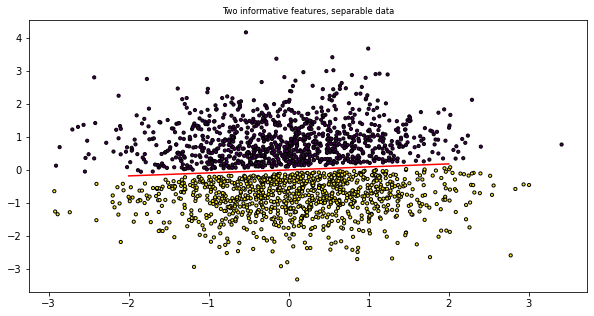

In [8]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_2000, y_2000, v_normal = make_classification_normal(2, 2000, rho=0.1)
draw_data_by_coord01(x_2000, y_2000, v_normal)

##### Comparison of linear and ada boost algorithms

In [9]:
start = time.time()
cnt = 0
margins_linear, margins_ada = [], []
while cnt < REPEAT_COUNT:
    X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE) #, random_state=42)
    #linear
    clf2000_linear = AdaBoostLinear_v1()
    _, _, _ = clf2000_linear.fit(X_train2000, y_train2000, allow_nonseparable=True)
    separated = accuracy_score(y_train2000, clf2000_linear.predict(X_train2000))
    if separated < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
        continue
    margins_linear.append(clf2000_linear.get_margin())
    #ada boost
    clf2000ada = AdaBoostJavaClassifier_v1(path=classpath)
    result = clf2000ada.fit(X_train2000, y_train2000)
    separated = accuracy_score(y_train2000, np.array(clf2000ada.predict(X_train2000)))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins_ada.append(clf2000ada.get_margin_l1(X_train2000))
    cnt += 1

end = time.time()
margin_linear = np.average(margins_linear)
print("Elapsed time: {}".format(end - start))
print("Linear average margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
margin_ada = np.average(margins_ada)
print("Ada boost average margin in {} experiments: {}".format(REPEAT_COUNT, margin_ada))

Elapsed time: 148.2056086063385
Linear average margin in 3 experiments: 0.3333333802636034
Ada boost average margin in 3 experiments: 0.3101617542391281


##### Metrics on different algorithms

In [10]:
#Linear clasifier
X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE)
clf2000L = AdaBoostLinear_v1()
_, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
print("LINEAR ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000L.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000L.predict(X_test2000), labels=[-1, 1])


LINEAR ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = -1,y = 1
a(x) = -1,327,0
a(x) = 1,0,333


In [11]:
#Ada boost clasifier
clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
_ = clf2000J.fit(X_train2000, y_train2000)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000J.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000J.predict(X_test2000), labels=[1, -1])

ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = 1,y = -1
a(x) = 1,333,0
a(x) = -1,0,327


##### Sklearn algorithm

In [12]:
clf2000std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2000std.fit(X_train2000, y_train2000)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000std.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000std.predict(X_test2000), labels=[-1, 1])

SKLEARN ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = -1,y = 1
a(x) = -1,327,0
a(x) = 1,0,333


### Separable data, 10 clusters, 50 features, 20 informative, train set - 667, test set - 333

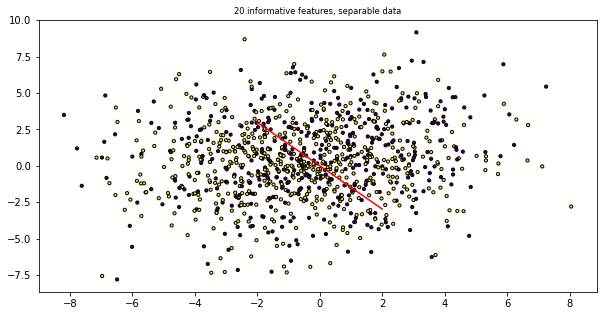

In [13]:
from sklearn.datasets import make_classification

x_1000, _ = make_classification(n_samples=1000, n_features=50,n_informative=20
                                , n_redundant=20, random_state=0, n_clusters_per_class=5, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("20 informative features, separable data", fontsize="small")
x_1000, y_1000, v_normal = make_separable_labels(x_1000, rho=0.1)
draw_data_by_coord01(x_1000, y_1000, v_normal)


##### Comparison of linear and ada boost algorithms

In [ ]:
start = time.time()
cnt = 0
margins_linear, accuracies_linear, margins_ada, accuracies_ada = [], [], [], []
while cnt < REPEAT_COUNT:
    X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
    #Linear
    clfL = AdaBoostLinear_v1()
    _, _, _ = clfL.fit(X_train1000, y_train1000, allow_nonseparable=True)
    separated = accuracy_score(y_train1000, clfL.predict(X_train1000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins_linear.append(clfL.get_margin())
    accuracies_linear.append(accuracy_score(y_test1000, clfL.predict(X_test1000)))
    #Ada boost
    clfJ = AdaBoostJavaClassifier_v1(path=classpath)
    result = clfJ.fit(X_train1000, y_train1000)
    separated = accuracy_score(y_train1000, clfJ.predict(X_train1000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins_ada.append(clfJ.get_margin_l1(X_train1000))
    accuracies_ada.append(accuracy_score(y_test1000, clfJ.predict(X_test1000)))
    cnt += 1

end = time.time()

print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(margins_linear), np.average(accuracies_linear)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(margins_ada), np.average(accuracies_ada)))


##### Metrics on different algorithms

In [ ]:
X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
clf1000L = AdaBoostLinear_v1()
_, _, _ = clf1000L.fit(X_train1000, y_train1000, allow_nonseparable=True)
print("LINEAR ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf1000L.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf1000L.predict(X_test1000), labels=[-1, 1])

In [ ]:
clf1000J = AdaBoostJavaClassifier_v1(path=classpath)
clf1000J.fit(X_train1000, y_train1000)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf1000J.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf1000J.predict(X_test1000), labels=[-1, 1])

In [ ]:
clf2std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2std.fit(X_train1000, y_train1000)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf2std.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf2std.predict(X_test1000), labels=[-1, 1])

### Breast cancer data set

In [ ]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/breast-cancer/'

df = pd.read_csv(path+'breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

In [ ]:
raw = df.to_numpy(copy=True)
x_data = raw[:, 1:10]
y_data = raw[:, 10].astype(int) - 3

print("Breast cancer: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

#### Check if dataset is separable

In [ ]:
from sklearn import svm

clf = svm.SVC(C = 10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)


##### Comparison of linear and ada boost algorithms

In [ ]:
start = time.time()
cnt = 0
marginsL, accuraciesL, marginsJ, accuraciesJ = [], [], [], []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        continue
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        continue

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Breast cancer data set, 9 features, 468 rows in train set, 231 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(marginsJ), np.average(accuraciesJ)))


##### Metrics on different algorithms

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

### Ionosphere

In [ ]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/ionosphere/'

df = pd.read_csv(path+'ionosphere.data', header=None)
df['decoded'] = df[34].apply(lambda x: -1 if x == 'b' else 1)
#df.fillna(0, inplace=True)
df.head(5)


In [ ]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([34, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)
print("Ionosphere: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

#### Check if dataset is separable

In [ ]:
from sklearn import svm

clf = svm.SVC(C=10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

##### Comparison of linear and ada boost algorithms

In [ ]:
REPEAT_COUNT2 = 10
start = time.time()
cnt = 0
marginsL, accuraciesL, marginsJ, accuraciesJ = [], [], [], []
while cnt < REPEAT_COUNT2:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        continue
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        continue

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Ionosphere data set, 34 features, 234 rows in train set, 117 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT2, np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT2, np.average(marginsJ), np.average(accuraciesJ)))


##### Metrics on different algorithms

In [ ]:
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

### Diabet

In [ ]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/diabet/'

df = pd.read_csv(path+'diabetes.data', header=None)
df['decoded'] = df[8].apply(lambda x: -1 if x == 'tested_negative' else 1)
df.head(5)

In [ ]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([8, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)

print("Diabet: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

#### Check if dataset is separable

In [ ]:
from sklearn import svm

clf = svm.SVC(C=10**8)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

In [ ]:
clf = AdaBoostLinear_v1()
result, message, _ = clf.fit(x_data, y_data, allow_nonseparable=True)
separated = accuracy_score(y_data, clf.predict(x_data))
print("Separated: {}, margin: {}".format(separated, clf.get_margin()))

#### Comparison of linear and ada boost algorithms

In [ ]:
start = time.time()
cnt, skips = 0, 0
SKIPS_LIMIT = 5
marginsL, accuraciesL, marginsJ, accuraciesJ = [], [], [], []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        skips += 1
        if skips < SKIPS_LIMIT:
            continue
        else:
            break
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        if skips < SKIPS_LIMIT:
            continue
        else:
            break

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Diabet data set, 8 features, 514 rows in train set, 254 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(len(marginsL), np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(len(marginsJ), np.average(marginsJ), np.average(accuraciesJ)))


#### Metrics on different algorithms

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

In [ ]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])